In [ ]:
from google.colab import files
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

class AirQualityDataLoader:
    def __init__(self, json_data):
        self.data = json_data
        self.scaler = MinMaxScaler()

    def load_and_prepare_data(self, sequence_length=7, grid_size=10):
        try:
            processed_data = []

            for date_key, date_data in self.data.items():
                for reading_id, reading in date_data.items():
                    if not isinstance(reading, dict):
                        continue

                    processed_data.append({
                        'date': reading['date'],
                        'latitude': float(reading['latitude']),
                        'longitude': float(reading['longitude']),
                        'pm25AQI': int(reading['pm25AQI']),
                        'vocIndex': int(reading['vocIndex']),
                        'weightedAQI': int(reading['weightedAQI'])
                    })

            df = pd.DataFrame(processed_data)
            df['date'] = pd.to_datetime(df['date'])

            print(f"Processed {len(processed_data)} readings across {len(df['date'].unique())} days")
            print("\nDate range:", df['date'].min(), "to", df['date'].max())

            return df

        except Exception as e:
            print(f"Error processing data: {e}")
            print("Current reading being processed:", reading)
            import traceback
            traceback.print_exc()
            return None

print("upload JSON file...")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
with open(filename, 'r') as f:
    full_data = json.load(f)

air_quality_data = full_data.get('air_quality_data', {})

print(f"\nLoaded data from {filename}")
print(f"Number of dates in dataset: {len(air_quality_data)}")

print("\nDates in dataset:")
for date in sorted(air_quality_data.keys()):
    reading_count = len(air_quality_data[date])
    print(f"- {date}: {reading_count} readings")

upload JSON file...


Saving firebase_dummy_data (14).json to firebase_dummy_data (14).json

Loaded data from firebase_dummy_data (14).json
Number of dates in dataset: 8

Dates in dataset:
- 2024-02-26: 100 readings
- 2024-02-27: 100 readings
- 2024-02-28: 100 readings
- 2024-02-29: 100 readings
- 2024-03-01: 100 readings
- 2024-03-02: 100 readings
- 2024-03-03: 100 readings
- 2024-03-04: 100 readings


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class AirQualityVAE(Model):
    def __init__(self, latent_dim=256, sequence_length=7, grid_size=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.sequence_length = sequence_length
        self.grid_size = grid_size
        self.scaler = MinMaxScaler()

        self.lat_bounds = None
        self.lon_bounds = None
        self.input_shape = None
        self.encoder = None
        self.decoder = None

        # Metrics
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.temporal_loss_tracker = tf.keras.metrics.Mean(name="temporal_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            self.temporal_loss_tracker,
            self.kl_loss_tracker
        ]

    def _set_bounds(self, df):
        """Set coordinate bounds based on input data"""
        self.lat_bounds = (df['latitude'].min(), df['latitude'].max())
        self.lon_bounds = (df['longitude'].min(), df['longitude'].max())
        print(f"Coordinate bounds set to:")
        print(f"Latitude: {self.lat_bounds[0]:.6f} to {self.lat_bounds[1]:.6f}")
        print(f"Longitude: {self.lon_bounds[0]:.6f} to {self.lon_bounds[1]:.6f}")

    def _build_encoder(self):
        encoder_inputs = layers.Input(shape=self.input_shape)

        daily_features = []
        for day in range(self.sequence_length):
            x_day = layers.Lambda(lambda x: x[:, day, :, :, :])(encoder_inputs)

            x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_day)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D((2, 2))(x)  # 32x32

            x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D((2, 2))(x)  # 16x16

            x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D((2, 2))(x)  # 8x8

            x = layers.Flatten()(x)
            daily_features.append(x)

        x = layers.Lambda(lambda x: tf.stack(x, axis=1))(daily_features)

        x = layers.LSTM(512, return_sequences=True)(x)
        x = layers.LSTM(256)(x)

        x = layers.Dense(1024, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        z_mean = layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(x)
        z = Sampling()([z_mean, z_log_var])

        return Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    def _build_decoder(self):
        latent_inputs = layers.Input(shape=(self.latent_dim,))

        x = layers.Dense(1024, activation='relu')(latent_inputs)
        x = layers.BatchNormalization()(x)

        x = layers.Dense(self.sequence_length * 256, activation='relu')(x)
        x = layers.Reshape((self.sequence_length, 256))(x)

        x = layers.LSTM(512, return_sequences=True)(x)

        daily_outputs = []
        for day in range(self.sequence_length):
            day_features = layers.Lambda(lambda x: x[:, day, :])(x)

            h_decoded = self.grid_size // 8
            day_features = layers.Dense(h_decoded * h_decoded * 256, activation='relu')(day_features)
            day_features = layers.Reshape((h_decoded, h_decoded, 256))(day_features)

            y = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(day_features)
            y = layers.BatchNormalization()(y)

            y = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(y)
            y = layers.BatchNormalization()(y)

            y = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(y)
            y = layers.BatchNormalization()(y)

            y = layers.Conv2D(3, (3, 3), padding='same', activation='linear')(y)

            daily_outputs.append(y)

        outputs = layers.Lambda(lambda x: tf.stack(x, axis=1))(daily_outputs)

        return Model(latent_inputs, outputs, name="decoder")

    def _build_networks(self):
        if self.input_shape is None:
            raise ValueError("Input shape must be set before building networks")
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()

    def create_spatiotemporal_sequences(self, df):
        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date')
        unique_dates = df['date'].unique()

        if len(unique_dates) < 8:
            raise ValueError("Need exactly 8 days of data")

        self._set_bounds(df)

        train_dates = unique_dates[:7]
        test_date = unique_dates[7]

        train_sequences = []
        for i in range(len(train_dates) - self.sequence_length + 1):
            sequence = np.zeros((self.sequence_length, self.grid_size, self.grid_size, 3))

            for j in range(self.sequence_length):
                date = train_dates[i + j]
                day_data = df[df['date'] == date]

                for _, row in day_data.iterrows():
                    x = int((row['latitude'] - self.lat_bounds[0]) /
                          (self.lat_bounds[1] - self.lat_bounds[0]) *
                          (self.grid_size - 1))
                    y = int((row['longitude'] - self.lon_bounds[0]) /
                          (self.lon_bounds[1] - self.lon_bounds[0]) *
                          (self.grid_size - 1))

                    x = min(max(x, 0), self.grid_size - 1)
                    y = min(max(y, 0), self.grid_size - 1)

                    sequence[j, x, y] = [
                        row['pm25AQI'],
                        row['vocIndex'],
                        row['weightedAQI']
                    ]

            train_sequences.append(sequence)

        test_sequence = np.zeros((1, self.sequence_length, self.grid_size, self.grid_size, 3))
        test_data = df[df['date'] == test_date]

        for _, row in test_data.iterrows():
            x = int((row['latitude'] - self.lat_bounds[0]) /
                  (self.lat_bounds[1] - self.lat_bounds[0]) *
                  (self.grid_size - 1))
            y = int((row['longitude'] - self.lon_bounds[0]) /
                  (self.lon_bounds[1] - self.lon_bounds[0]) *
                  (self.grid_size - 1))

            x = min(max(x, 0), self.grid_size - 1)
            y = min(max(y, 0), self.grid_size - 1)

            test_sequence[0, -1, x, y] = [
                row['pm25AQI'],
                row['vocIndex'],
                row['weightedAQI']
            ]

        train_sequences = np.array(train_sequences)
        original_shape = train_sequences.shape
        flattened_data = train_sequences.reshape(-1, train_sequences.shape[-1])
        scaled_data = self.scaler.fit_transform(flattened_data)
        train_sequences = scaled_data.reshape(original_shape)

        test_shape = test_sequence.shape
        test_flattened = test_sequence.reshape(-1, test_sequence.shape[-1])
        test_scaled = self.scaler.transform(test_flattened)
        test_sequence = test_scaled.reshape(test_shape)

        if self.input_shape is None:
            self.input_shape = train_sequences.shape[1:]
            self._build_networks()

        return train_sequences, test_sequence

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.mse(data, reconstruction)
            )

            temporal_loss = 0
            for t in range(1, self.sequence_length):
                temp_diff = reconstruction[:, t] - reconstruction[:, t-1]
                actual_diff = data[:, t] - data[:, t-1]
                temporal_loss += tf.reduce_mean(tf.keras.losses.mse(temp_diff, actual_diff))

            temporal_loss /= (self.sequence_length - 1)

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = reconstruction_loss + 0.3 * temporal_loss + 0.01 * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.temporal_loss_tracker.update_state(temporal_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "temporal_loss": self.temporal_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "loss": total_loss
        }

    #generates forecast using last sequence
    def generate_forecast(self, last_sequence):
        z_mean, _, _ = self.encoder(last_sequence)
        forecast = self.decoder(z_mean)

        if isinstance(forecast, tf.Tensor):
            forecast = forecast.numpy()

        return forecast

    #takes grid prediction, target lat. target lon, and generates interpolated GPS values
    def interpolate_gps_prediction(self, grid_prediction, target_lat, target_lon):
        x = (target_lat - self.lat_bounds[0]) / (self.lat_bounds[1] - self.lat_bounds[0]) * (self.grid_size - 1)
        y = (target_lon - self.lon_bounds[0]) / (self.lon_bounds[1] - self.lon_bounds[0]) * (self.grid_size - 1)

        x0, x1 = int(np.floor(x)), int(np.ceil(x))
        y0, y1 = int(np.floor(y)), int(np.ceil(y))

        x0 = max(0, min(x0, self.grid_size - 1))
        x1 = max(0, min(x1, self.grid_size - 1))
        y0 = max(0, min(y0, self.grid_size - 1))
        y1 = max(0, min(y1, self.grid_size - 1))

        wx = x - x0
        wy = y - y0

        values = []
        for metric in range(3):
            v00 = grid_prediction[x0, y0, metric]
            v01 = grid_prediction[x0, y1, metric]
            v10 = grid_prediction[x1, y0, metric]
            v11 = grid_prediction[x1, y1, metric]

            value = (v00 * (1 - wx) * (1 - wy) +
                    v01 * (1 - wx) * wy +
                    v10 * wx * (1 - wy) +
                    v11 * wx * wy)

            values.append(float(value))

        return np.array(values)

    #takes dataframe with 7 days of data and list of lat lon tuples to predict for
    #returns a list of predictions for each
    def predict_for_locations(self, seven_day_data, target_locations):
        sequences = self.create_spatiotemporal_sequences(seven_day_data, is_prediction=True)
        grid_prediction = self.generate_forecast(sequences[-1:])
        grid_prediction = grid_prediction[0, -1]  # Get last timestep

        predictions = []
        for lat, lon in target_locations:
            pred = self.interpolate_gps_prediction(grid_prediction, lat, lon)
            predictions.append({
                'latitude': lat,
                'longitude': lon,
                'pm25_aqi': pred[0],
                'voc_index': pred[1],
                'weighted_aqi': pred[2]
            })

        return predictions

    #reconstruction evaluation metrics
    def evaluate_reconstruction(self, train_sequences):
        metrics = ['PM2.5 AQI', 'VOC Index', 'Weighted AQI']

        z_mean, z_log_var, z = self.encoder(train_sequences)
        reconstructions = self.decoder(z)

        if isinstance(reconstructions, tf.Tensor):
            reconstructions = reconstructions.numpy()
        originals = train_sequences
        if isinstance(originals, tf.Tensor):
            originals = originals.numpy()

        orig_shape = originals.shape
        recon_shape = reconstructions.shape

        originals_flat = originals.reshape(-1, originals.shape[-1])
        reconstructions_flat = reconstructions.reshape(-1, reconstructions.shape[-1])

        originals_unscaled = self.scaler.inverse_transform(originals_flat)
        reconstructions_unscaled = self.scaler.inverse_transform(reconstructions_flat)

        originals = originals_unscaled.reshape(orig_shape)
        reconstructions = reconstructions_unscaled.reshape(recon_shape)

        for i, metric in enumerate(metrics):
            print(f"\n=== {metric} Reconstruction Analysis ===")

            orig_values = originals[..., i].flatten()
            recon_values = reconstructions[..., i].flatten()

            mae = np.mean(np.abs(orig_values - recon_values))
            rmse = np.sqrt(np.mean((orig_values - recon_values)**2))

            orig_stats = {
                'mean': np.mean(orig_values),
                'std': np.std(orig_values),
                'median': np.median(orig_values),
                'q1': np.percentile(orig_values, 25),
                'q3': np.percentile(orig_values, 75),
                'min': np.min(orig_values),
                'max': np.max(orig_values)
            }

            recon_stats = {
                'mean': np.mean(recon_values),
                'std': np.std(recon_values),
                'median': np.median(recon_values),
                'q1': np.percentile(recon_values, 25),
                'q3': np.percentile(recon_values, 75),
                'min': np.min(recon_values),
                'max': np.max(recon_values)
            }

            from scipy import stats
            ks_stat, ks_p = stats.ks_2samp(orig_values, recon_values)

            temporal_consistency = []
            for seq_idx in range(len(originals)):
                orig_seq = originals[seq_idx, ..., i]
                recon_seq = reconstructions[seq_idx, ..., i]

                #day to day change calculation
                orig_changes = np.diff(orig_seq.mean(axis=(0, 1)))
                recon_changes = np.diff(recon_seq.mean(axis=(0, 1)))

                #change correlation
                temp_corr = np.corrcoef(orig_changes, recon_changes)[0, 1]
                temporal_consistency.append(temp_corr)

            from skimage.metrics import structural_similarity as ssim
            spatial_consistency = []
            for day in range(originals.shape[1]):
                for seq_idx in range(len(originals)):
                    orig_map = originals[seq_idx, day, ..., i]
                    recon_map = reconstructions[seq_idx, day, ..., i]

                    similarity = ssim(orig_map, recon_map,
                                    data_range=orig_map.max()-orig_map.min())
                    spatial_consistency.append(similarity)

            print("\nReconstruction Error Metrics:")
            print(f"MAE: {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")

            print("\nDistribution Statistics:")
            print("Original:", orig_stats)
            print("Reconstructed:", recon_stats)

            print("\nDistribution Similarity:")
            print(f"KS Statistic: {ks_stat:.3f} (p-value: {ks_p:.3f})")

            print("\nTemporal Consistency:")
            print(f"Mean temporal correlation: {np.mean(temporal_consistency):.3f}")
            print(f"Std temporal correlation: {np.std(temporal_consistency):.3f}")

            print("\nSpatial Consistency:")
            print(f"Mean SSIM: {np.mean(spatial_consistency):.3f}")
            print(f"Std SSIM: {np.std(spatial_consistency):.3f}")

            plt.figure(figsize=(15, 5))

            plt.subplot(131)
            plt.hist(orig_values, bins=50, alpha=0.5, label='Original', density=True)
            plt.hist(recon_values, bins=50, alpha=0.5, label='Reconstructed', density=True)
            plt.title(f'{metric} Distribution')
            plt.legend()

            plt.subplot(132)
            stats.probplot(orig_values, dist="norm", plot=plt)
            plt.title("Q-Q Plot Original")

            plt.subplot(133)
            stats.probplot(recon_values, dist="norm", plot=plt)
            plt.title("Q-Q Plot Reconstructed")

            plt.tight_layout()
            plt.show()

            plt.figure(figsize=(15, 5))

            seq_idx = 0
            orig_seq = originals[seq_idx, :, :, :, i].mean(axis=(1, 2))
            recon_seq = reconstructions[seq_idx, :, :, :, i].mean(axis=(1, 2))

            plt.plot(orig_seq, label='Original', marker='o')
            plt.plot(recon_seq, label='Reconstructed', marker='o')
            plt.title(f'{metric} Temporal Pattern (Example Sequence)')
            plt.xlabel('Time Step')
            plt.ylabel('Average Value')
            plt.legend()
            plt.show()

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

            day_idx = 0
            seq_idx = 0

            orig_map = originals[seq_idx, day_idx, :, :, i]
            recon_map = reconstructions[seq_idx, day_idx, :, :, i]
            diff_map = orig_map - recon_map

            vmin = min(orig_map.min(), recon_map.min())
            vmax = max(orig_map.max(), recon_map.max())

            im1 = ax1.imshow(orig_map, cmap='viridis', vmin=vmin, vmax=vmax)
            ax1.set_title('Original')
            plt.colorbar(im1, ax=ax1)

            im2 = ax2.imshow(recon_map, cmap='viridis', vmin=vmin, vmax=vmax)
            ax2.set_title('Reconstructed')
            plt.colorbar(im2, ax=ax2)

            #difference plot
            max_abs_diff = max(abs(diff_map.min()), abs(diff_map.max()))
            im3 = ax3.imshow(diff_map, cmap='RdBu', vmin=-max_abs_diff, vmax=max_abs_diff)
            ax3.set_title('Difference')
            plt.colorbar(im3, ax=ax3)

            plt.suptitle(f'{metric} Spatial Pattern (Example)')
            plt.tight_layout()
            plt.show()

        return {
            'mae': mae,
            'rmse': rmse,
            'ks_stat': ks_stat,
            'temporal_consistency': np.mean(temporal_consistency),
            'spatial_consistency': np.mean(spatial_consistency)
        }

    #vanilla evaluation function
    def evaluate_forecast(self, test_sequence, actual_sequence):
        """Evaluate forecast against actual data"""
        metrics = ['PM2.5 AQI', 'VOC Index', 'Weighted AQI']

        forecast = test_sequence[0, -1]
        actual = actual_sequence[0, -1]

        if isinstance(forecast, tf.Tensor):
            forecast = forecast.numpy()
        if isinstance(actual, tf.Tensor):
            actual = actual.numpy()

        forecast_flat = forecast.reshape(-1, forecast.shape[-1])
        actual_flat = actual.reshape(-1, actual.shape[-1])

        forecast_unscaled = self.scaler.inverse_transform(forecast_flat)
        actual_unscaled = self.scaler.inverse_transform(actual_flat)

        forecast = forecast_unscaled.reshape(forecast.shape)
        actual = actual_unscaled.reshape(actual.shape)

        mse = np.mean((forecast - actual) ** 2, axis=(0, 1))
        mae = np.mean(np.abs(forecast - actual), axis=(0, 1))

        print("\nForecast Evaluation Metrics:")
        for i, metric in enumerate(metrics):
            print(f"\n{metric}:")
            print(f"MSE: {mse[i]:.2f}")
            print(f"MAE: {mae[i]:.2f}")

        return mse, mae

    def visualize_forecast_comparison(self, test_sequence, actual_sequence):
        metrics = ['PM2.5 AQI', 'VOC Index', 'Weighted AQI']

        forecast = test_sequence[0, -1]
        actual = actual_sequence[0, -1]

        if isinstance(forecast, tf.Tensor):
            forecast = forecast.numpy()
        if isinstance(actual, tf.Tensor):
            actual = actual.numpy()

        forecast_flat = forecast.reshape(-1, forecast.shape[-1])
        actual_flat = actual.reshape(-1, actual.shape[-1])

        forecast_unscaled = self.scaler.inverse_transform(forecast_flat)
        actual_unscaled = self.scaler.inverse_transform(actual_flat)

        forecast = forecast_unscaled.reshape(forecast.shape)
        actual = actual_unscaled.reshape(actual.shape)

        #generate visualizations
        for m in range(3):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

            vmin = min(actual[:, :, m].min(), forecast[:, :, m].min())
            vmax = max(actual[:, :, m].max(), forecast[:, :, m].max())

            #actual
            im1 = ax1.imshow(actual[:, :, m], cmap='viridis', vmin=vmin, vmax=vmax)
            ax1.set_title(f'Actual {metrics[m]}')
            plt.colorbar(im1, ax=ax1)

            #forecast
            im2 = ax2.imshow(forecast[:, :, m], cmap='viridis', vmin=vmin, vmax=vmax)
            ax2.set_title(f'Forecast {metrics[m]}')
            plt.colorbar(im2, ax=ax2)

            #difference
            diff = actual[:, :, m] - forecast[:, :, m]
            vmax_diff = max(abs(np.min(diff)), abs(np.max(diff)))
            vmin_diff = -vmax_diff
            im3 = ax3.imshow(diff, cmap='RdBu', vmin=vmin_diff, vmax=vmax_diff)
            ax3.set_title('Difference (Actual - Forecast)')
            plt.colorbar(im3, ax=ax3)

            plt.suptitle(f'{metrics[m]} Forecast Comparison')
            plt.tight_layout()
            plt.show()

            print(f"\n{metrics[m]} Statistics:")
            print(f"Actual range: {actual[:,:,m].min():.2f} to {actual[:,:,m].max():.2f}")
            print(f"Forecast range: {forecast[:,:,m].min():.2f} to {forecast[:,:,m].max():.2f}")
            print(f"Mean absolute difference: {np.mean(np.abs(diff)):.2f}")

    def fit_with_preprocessing(self, df, epochs=500, batch_size=32):
        train_sequences, test_sequence = self.create_spatiotemporal_sequences(df)

        if not hasattr(self, 'optimizer'):
            self.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

        history = self.fit(
            train_sequences,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='loss',
                    mode='min',
                    patience=50,
                    min_delta=1e-5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='loss',
                    factor=0.5,
                    patience=20,
                    min_lr=1e-6
                )
            ]
        )

        prediction = self.generate_forecast(train_sequences[-1:])

        return history, train_sequences, test_sequence, prediction

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        unscaled_reconstruction = self.unscale_outputs(reconstruction)
        return unscaled_reconstruction

    #reshape, convert, inverse transform
    def unscale_outputs(self, x):
        original_shape = x.shape
        x_2d = tf.reshape(x, [-1, x.shape[-1]])

        scale = tf.constant(self.scaler.scale_, dtype=tf.float32)
        min_val = tf.constant(self.scaler.min_, dtype=tf.float32)
        data_range = tf.constant(self.scaler.data_range_, dtype=tf.float32)
        data_min = tf.constant(self.scaler.data_min_, dtype=tf.float32)

        x_std = (x_2d - min_val) / scale
        x_original = x_std * data_range + data_min

        return tf.reshape(x_original, original_shape)


    def visualize_predictions(self, sequences, n_samples=2):
        reconstructions = self.predict(sequences)

        original_shape = sequences.shape
        sequences_rescaled = self.scaler.inverse_transform(
            sequences.reshape(-1, sequences.shape[-1])
        ).reshape(original_shape)

        reconstructions_rescaled = self.scaler.inverse_transform(
            reconstructions.reshape(-1, reconstructions.shape[-1])
        ).reshape(original_shape)

        metrics = ['PM2.5 AQI', 'VOC Index', 'Weighted AQI']

        for i in range(min(n_samples, len(sequences))):
            for m in range(3):
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

                #original
                im1 = ax1.imshow(sequences_rescaled[i, -1, :, :, m], cmap='viridis')
                ax1.set_title(f'Original {metrics[m]}')
                plt.colorbar(im1, ax=ax1)

                #reconstructed
                im2 = ax2.imshow(reconstructions_rescaled[i, -1, :, :, m], cmap='viridis')
                ax2.set_title(f'Reconstructed {metrics[m]}')
                plt.colorbar(im2, ax=ax2)

                #difference
                diff = sequences_rescaled[i, -1, :, :, m] - reconstructions_rescaled[i, -1, :, :, m]
                vmax = max(abs(diff.min()), abs(diff.max()))
                vmin = -vmax
                im3 = ax3.imshow(diff, cmap='RdBu', vmin=vmin, vmax=vmax)
                ax3.set_title('Difference')
                plt.colorbar(im3, ax=ax3)

                plt.suptitle(f'{metrics[m]} Comparison')
                plt.tight_layout()
                plt.show()

    def generate_forecast(self, last_sequence):
        z_mean, _, _ = self.encoder(last_sequence)
        forecast = self.decoder(z_mean)

        forecast_np = forecast.numpy()
        original_shape = forecast_np.shape

        forecast_flat = forecast_np.reshape(-1, forecast_np.shape[-1])
        forecast_unscaled = self.scaler.inverse_transform(forecast_flat)
        forecast_rescaled = forecast_unscaled.reshape(original_shape)

        return forecast_rescaled




Processed 800 readings across 8 days

Date range: 2024-02-26 00:00:00 to 2024-03-04 00:00:00
Coordinate bounds set to:
Latitude: 47.648137 to 47.663835
Longitude: -122.314170 to -122.293830
Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - kl_loss: 2.5086e-05 - loss: 0.0029 - reconstruction_loss: 0.0019 - temporal_loss: 0.0035 - learning_rate: 0.0010
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - kl_loss: 2.1600e-05 - loss: 0.0029 - reconstruction_loss: 0.0019 - temporal_loss: 0.0035 - learning_rate: 0.0010
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - kl_loss: 1.7489e-05 - loss: 0.0029 - reconstruction_loss: 0.0019 - temporal_loss: 0.0035 - learning_rate: 0.0010
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - kl_loss: 1.3448e-05 - loss: 0.0029 - reconstruction_loss: 0.0019 - temporal_loss: 0.0035 - learning_rate: 0.0010
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - kl_loss: 9.8736e-06 - loss: 0.0029 - reconstruction_loss: 0.0018 - temporal_loss: 0.0034 - learning_rate: 

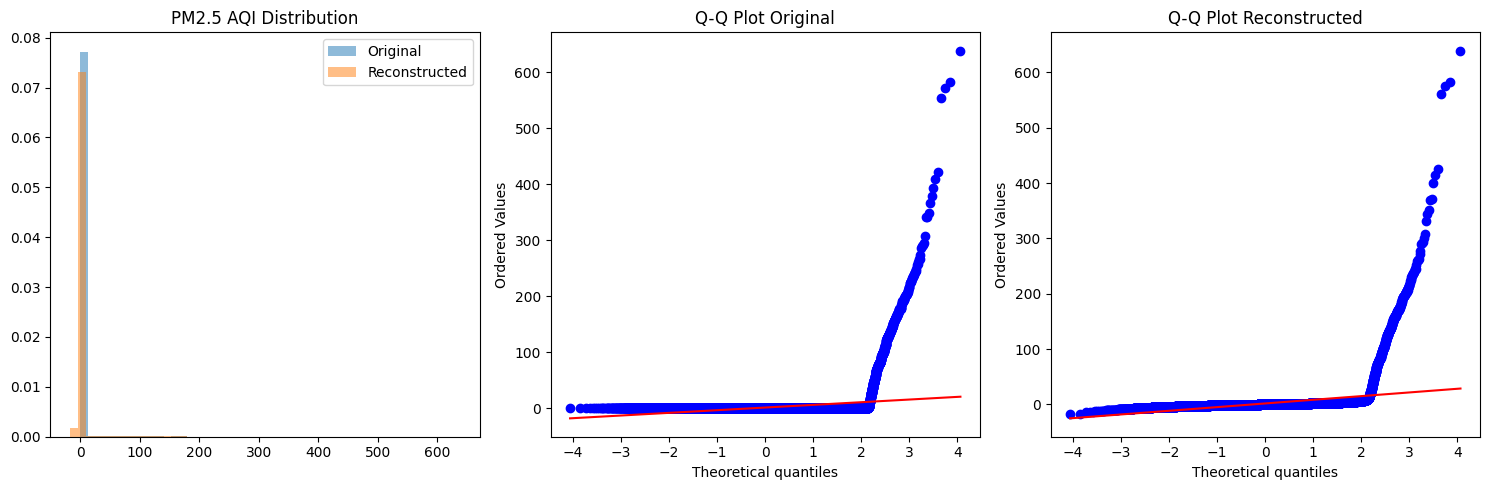

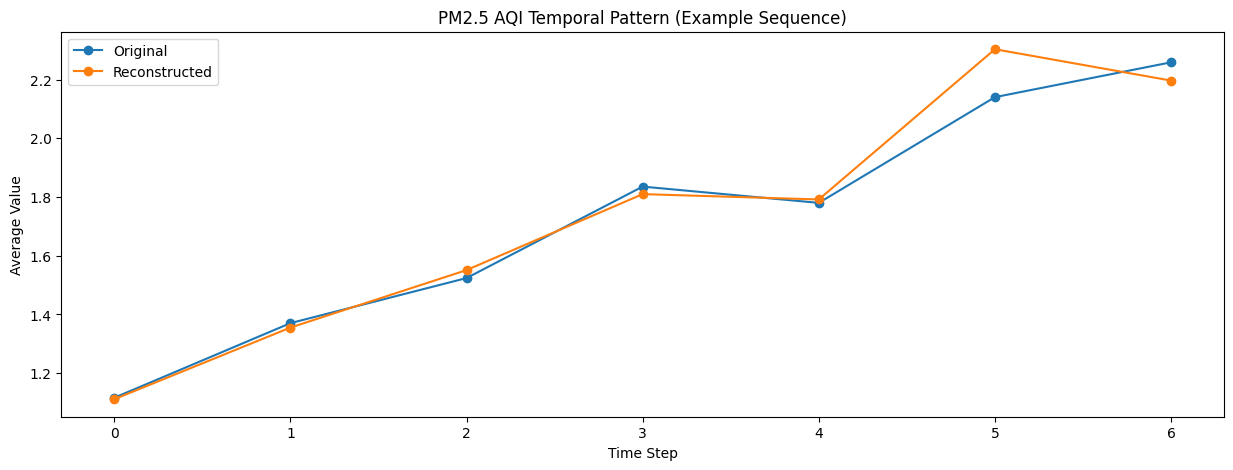

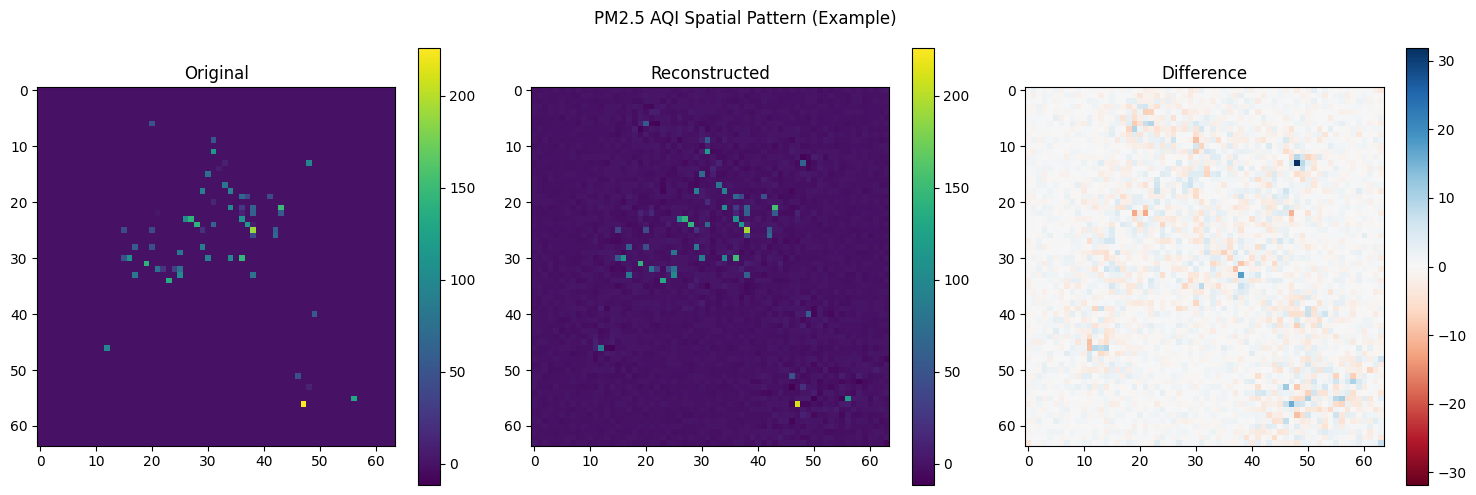


=== VOC Index Reconstruction Analysis ===

Reconstruction Error Metrics:
MAE: 0.50
RMSE: 0.70

Distribution Statistics:
Original: {'mean': 1.5892857142857142, 'std': 12.48506840971058, 'median': 0.0, 'q1': 0.0, 'q3': 0.0, 'min': 0.0, 'max': 216.0}
Reconstructed: {'mean': 1.6752375, 'std': 12.603155, 'median': 0.06478375, 'q1': -0.2940773516893387, 'q3': 0.46042241901159286, 'min': -9.642335, 'max': 217.65608}

Distribution Similarity:
KS Statistic: 0.528 (p-value: 0.000)

Temporal Consistency:
Mean temporal correlation: 0.999
Std temporal correlation: 0.000

Spatial Consistency:
Mean SSIM: 0.985
Std SSIM: 0.004


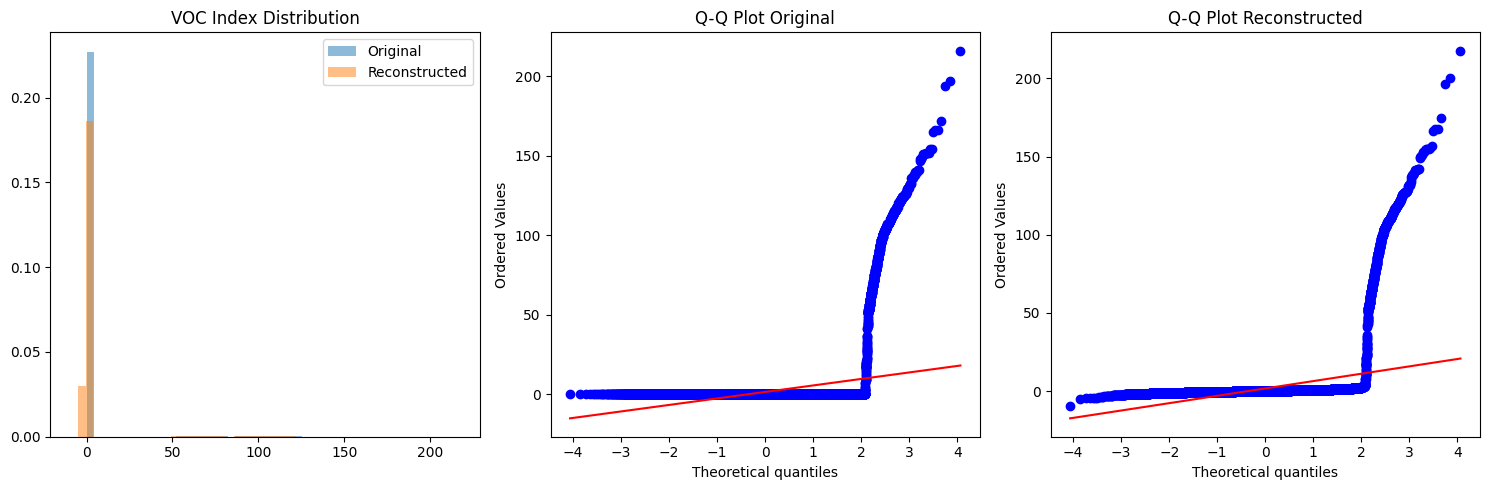

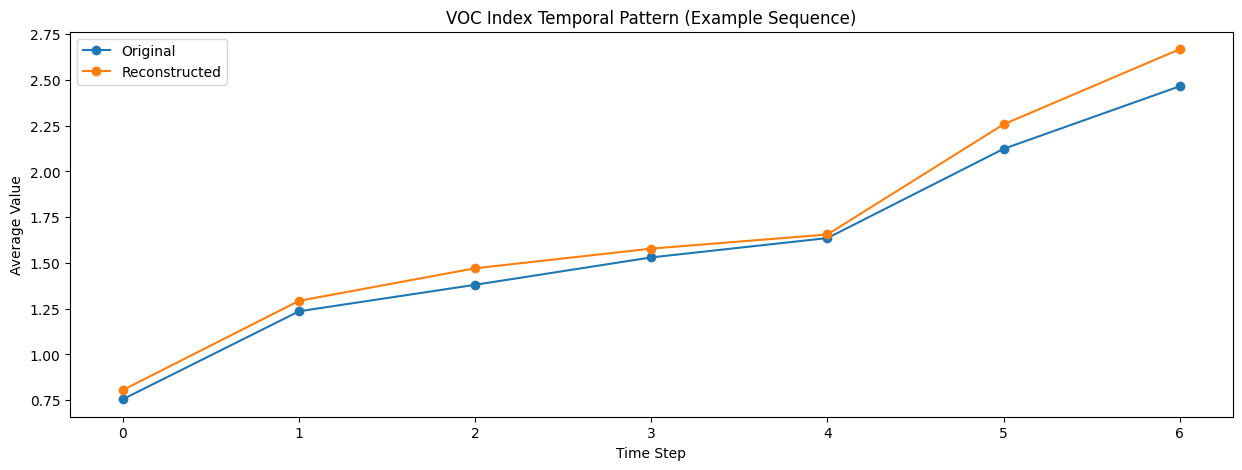

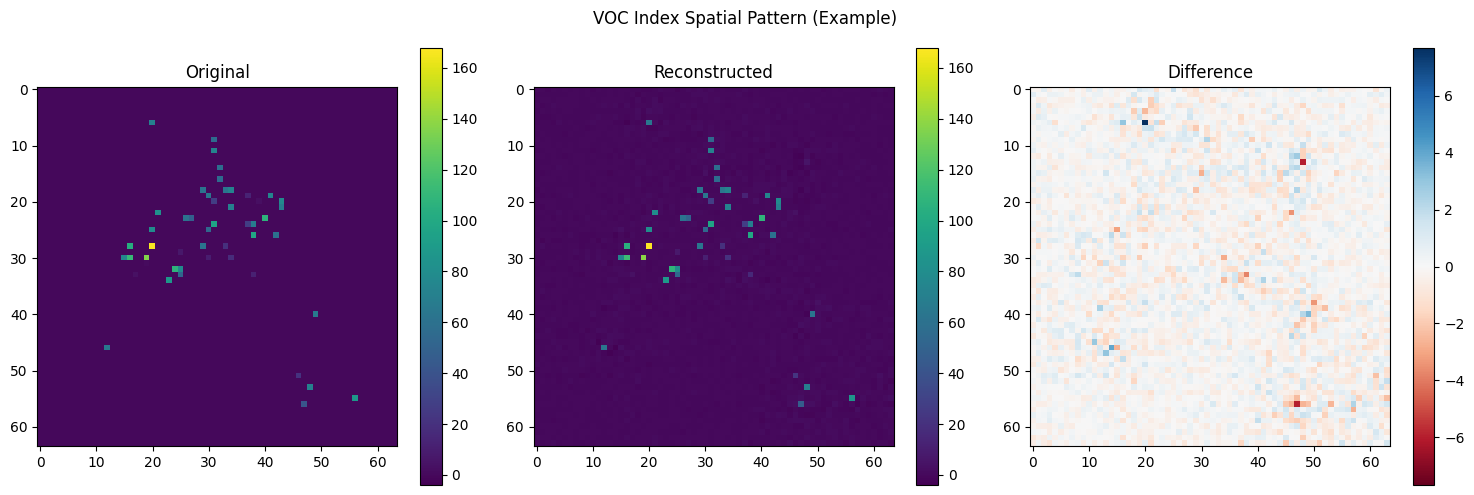


=== Weighted AQI Reconstruction Analysis ===

Reconstruction Error Metrics:
MAE: 0.77
RMSE: 1.08

Distribution Statistics:
Original: {'mean': 1.5469098772321428, 'std': 12.537281048651751, 'median': 0.0, 'q1': 0.0, 'q3': 0.0, 'min': 0.0, 'max': 328.0}
Reconstructed: {'mean': 1.6143568, 'std': 12.679121, 'median': 0.044375893, 'q1': -0.5061758160591125, 'q3': 0.6551720649003983, 'min': -9.526122, 'max': 330.95514}

Distribution Similarity:
KS Statistic: 0.500 (p-value: 0.000)

Temporal Consistency:
Mean temporal correlation: 0.994
Std temporal correlation: 0.000

Spatial Consistency:
Mean SSIM: 0.977
Std SSIM: 0.012


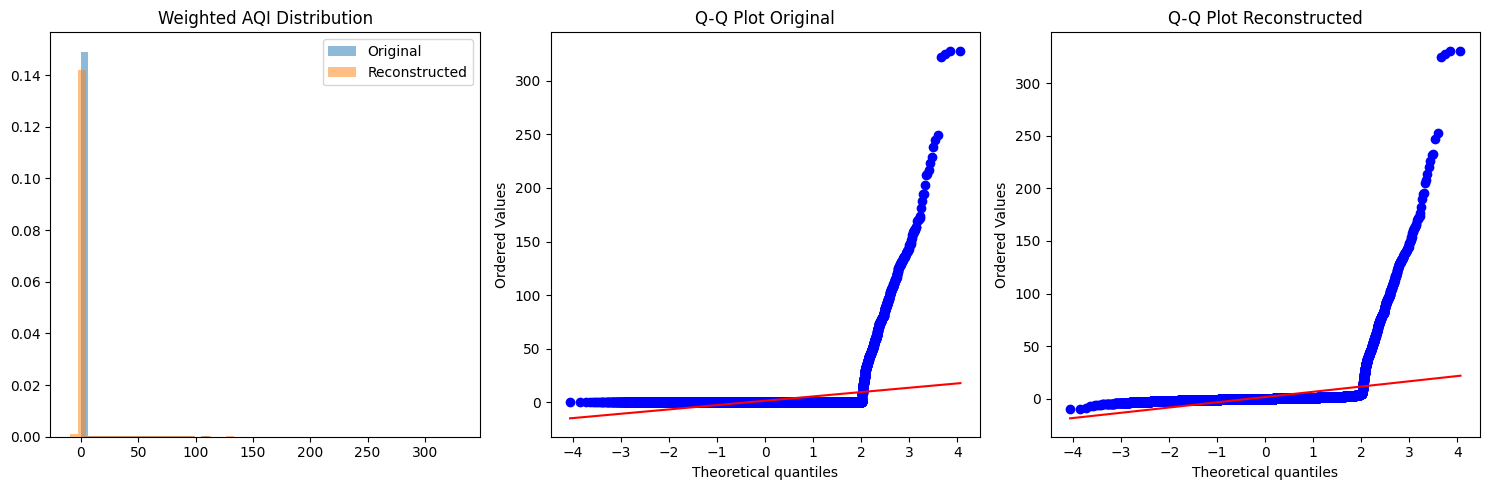

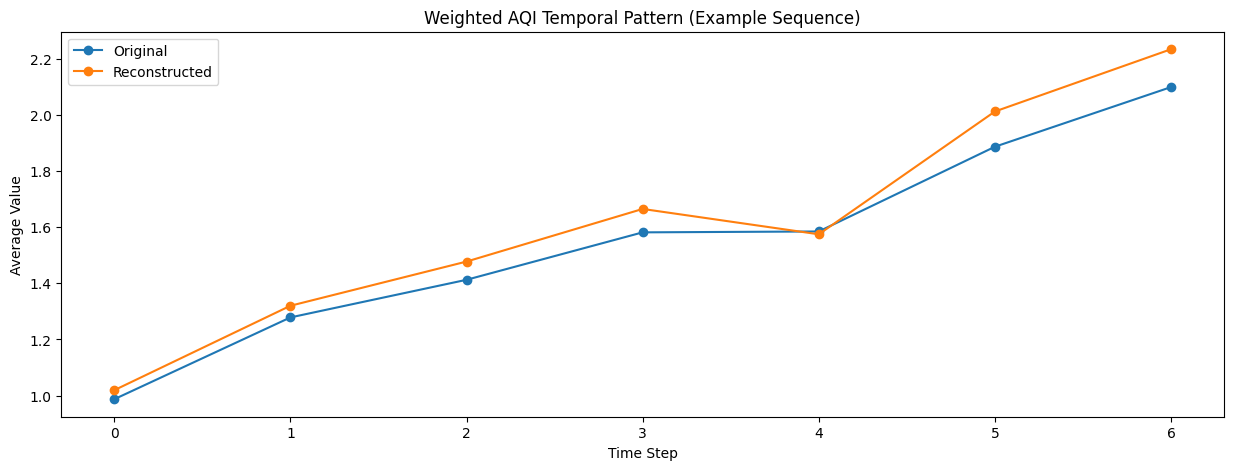

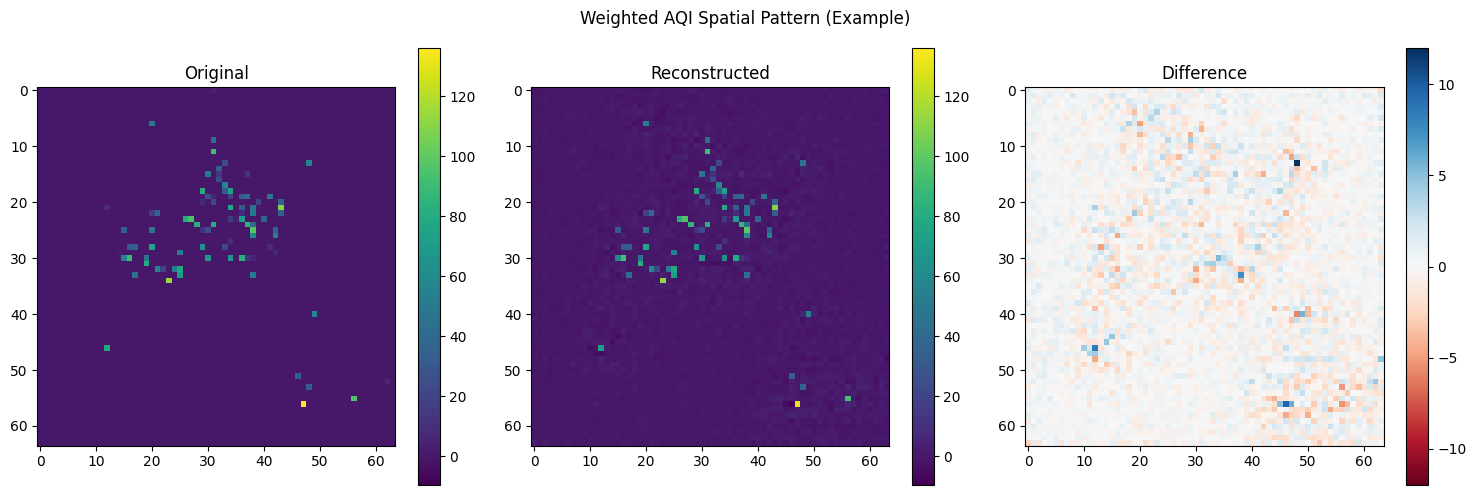

In [ ]:
data_loader = AirQualityDataLoader(air_quality_data)
df = data_loader.load_and_prepare_data()

model = AirQualityVAE()
history, train_sequences, test_sequence, prediction = model.fit_with_preprocessing(df)

reconstruction_results = model.evaluate_reconstruction(train_sequences)

In [ ]:
def save_for_deployment(self, output_path="air_quality_model"):
    """Save model with unscaled outputs"""
    @tf.function(input_signature=[
        tf.TensorSpec(shape=[1, self.sequence_length, self.grid_size, self.grid_size, 3],
                      dtype=tf.float32)
    ])
    def predict_with_unscaling(x):
        z_mean, _, _ = self.encoder(x)
        decoded = self.decoder(z_mean)
        return self.unscale_outputs(decoded)

    converter = tf.lite.TFLiteConverter.from_concrete_functions(
        [predict_with_unscaling.get_concrete_function()]
    )
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float32]
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]

    tflite_model = converter.convert()

    with open(f"{output_path}.tflite", 'wb') as f:
        f.write(tflite_model)

    params = {
        'lat_bounds': self.lat_bounds,
        'lon_bounds': self.lon_bounds,
        'grid_size': self.grid_size,
        'sequence_length': self.sequence_length,
        'scaler': {
            'scale_': self.scaler.scale_.tolist(),
            'min_': self.scaler.min_.tolist(),
            'data_min_': self.scaler.data_min_.tolist(),
            'data_max_': self.scaler.data_max_.tolist(),
            'data_range_': self.scaler.data_range_.tolist()
        }
    }

    with open(f"{output_path}_params.json", 'w') as f:
        json.dump(params, f)


    print(f"Model and parameters saved to {output_path}")
    print(f"Files created:")
    print(f"- {output_path}.tflite (TFLite model)")
    print(f"- {output_path}_params.json (Preprocessing parameters)")
    print(f"- {output_path}_weights.weights.h5 (Model weights)")



save_for_deployment(model, "air_quality_model")

Model and parameters saved to air_quality_model
Files created:
- air_quality_model.tflite (TFLite model)
- air_quality_model_params.json (Preprocessing parameters)
- air_quality_model_weights.weights.h5 (Model weights)


In [ ]:
from google.colab import files

files.download("air_quality_model.tflite")

files.download("air_quality_model_params.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>